# Introduction
In the last notebook, I showed you how easy it is to connect jQAssistant/neo4j with Python Pandas/py2neo. In this notebook, I show you a (at first glance) simple analysis of the Git repository https://github.com/feststelltaste/spring-petclinic. This repository is a fork of the demo repository for jQAssistant (https://github.com/feststelltaste/spring-petclinic) therefore it integrates jQAssistant already.

As analysis task, we want to know who are the Top 10 committers and how the distribution of the commits is. This could be handy if you want to identify your main contributors of a project e. g. to send them a gift at Christmas ;-) .

But first, you might ask yourself: "Why do I need a fully fledged data analysis framework like Pandas for such a simple task? Are there no standard tools out there?" Well, I'll show you why (OK, and you got me there: I needed another reason to go deeper with Python, Pandas, jQAssistant and Neo4j to get some serious software data analysis started) 

So let's go!

# Preparation

This notebook assumes that 
- there is a running Neo4j server with the default configuration. 
- the graph database is filled with the scan results of jQAssistant (happens for the repository above automatically with an <tt>mvn clean install</tt>)
- you use a standard Anaconda installation with Python 3+
- you installed the py2neo connector

If everything is set up, we just import the usual suspects: py2neo for connecting to Neo4j and Pandas for data analysis. We also want to plot some graphics later on, so we import matplotlib accordingly as the convention suggests.

In [1]:
import py2neo
import pandas as pd
import matplotlib.pyplot as plt
# display graphics directly in the notebook
%matplotlib inline

# Data input

We need some data to get started. Luckily, we have jQAssistant at our hand. It's integrated into the build process of Spring PetClinic repository above and scanned the Git repository information automatically with every executed build. 

So let's query our almighty Neo4j graph database that holds all the structural data about the software project. 

In [2]:
graph = py2neo.Graph()
query = """
MATCH (author:Author)-[:COMMITED]-> (commit:Commit)
RETURN author.name as name, author.email as email
"""
result = graph.data(query)
# just how first three entries
result[0:3]

[{'email': 'feststelltaste@googlemail.com', 'name': 'Markus Harrer'},
 {'email': 'feststelltaste@googlemail.com', 'name': 'feststelltaste'},
 {'email': 'feststelltaste@googlemail.com', 'name': 'feststelltaste'}]

The query returns all commits with their authors and the author's email addresses. We get some nice, tabular data that we put into Pandas's DataFrame.

In [3]:
commits = pd.DataFrame(result)
commits.head()

,email,name
0,feststelltaste@googlemail.com,Markus Harrer
1,feststelltaste@googlemail.com,feststelltaste
2,feststelltaste@googlemail.com,feststelltaste
3,feststelltaste@googlemail.com,feststelltaste
4,feststelltaste@googlemail.com,feststelltaste


# Familiarization

First, I like to check the raw data a little bit. I often do this by first having a look at the data types the data source is returning. It's a good starting point to check that Pandas recognizes the data types accordingly. You can also use this approach to check for skewed data columns very quickly (especially necessary when reading CSV or Excel files): If there should be a column with a specific data type (e. g. because the documentation of the dataset said so), the data type should  be recognized automatically as specified. If not, there is a high probability that the imported data source isn't correct (and we have a data quality problem).

In [4]:
commits.dtypes

email    object
name     object
dtype: object

That's OK for our simple scenario. The two columns with texts are objects &ndash; nothing spectacular.

In the next step, I always like to get a "feeling" of all the data. Primarily, I want to get a quick impression of the data quality again. It could always be that there is "dirty data" in the dataset or that there are outliers that would screw up the analysis. With such a small amount of data we have, we can simply list all unique values that occur in the columns. I just list the top 10's for both columns.

In [5]:
commits['name'].value_counts()[0:10]

Mic                   211
Antoine Rey           112
michaelisvy            87
Dirk Mahler            50
Keith Donald           35
Costin Leau            28
feststelltaste         26
Cyrille Le Clerc        5
Thibault Duchateau      5
Dapeng                  5
Name: name, dtype: int64

OK, at first glance, something seems awkward. Let's have a look at the email addresses.

In [6]:
commits['email'].value_counts()[0:10]

misvy@vmware.com                 224
misvy@gopivotal,com               63
antoine.rey@gmail.com             59
antoine.rey@free.fr               53
dirk.mahler@buschmais.com         46
kdonald@vmware.com                35
cleau@vmware.com                  28
feststelltaste@googlemail.com     27
misvy@gopivotal.com               11
verydapeng@gmail.com               5
Name: email, dtype: int64

OK, the bad feeling is strengthening. We might have a problem with multiple authors having multiple email addresses. Let me show you the problem by better representing the problem.

## Interlude - begin
_In the interlude section, I take you to a short, mostly undocumented excursion with probably messy code (don't do this at home!) to make a point. If you like, you can skip that section._

**Goal: Create a diagram that shows the relationship between the authors and the emails addresses.**

(Note to myself: It's probably better to solve that directly in Neo4j the next time ;-) )

I need a unique index for each name and I have to calculate the number of different email addresses per author.

In [7]:
grouped_by_authors = commits[['name', 'email']]\
   .drop_duplicates().groupby('name').count()\
    .sort_values('email', ascending=False).reset_index().reset_index()
grouped_by_authors.head()

,index,name,email
0,0,michaelisvy,3
1,1,Ameya Pandilwar,2
2,2,Dirk Mahler,2
3,3,Antoine Rey,2
4,4,Rossen Stoyanchev,1


Same procedure for the email addresses.

In [8]:
grouped_by_email = commits[['name', 'email']]\
   .drop_duplicates().groupby('email').count()\
    .sort_values('name', ascending=False).reset_index().reset_index()
grouped_by_email.head()

,index,email,name
0,0,feststelltaste@googlemail.com,2
1,1,misvy@vmware.com,2
2,2,Andrej1,1
3,3,jdubois@ippon.fr,1
4,4,kdonald@vmware.com,1


Then I merge the two DataFrames with a subset of the original data. I get each author and email index as well as the number of occurrences for author respectively emails. I only need the ones that are occurring multiple times, so I check for > 2.

In [9]:
plot_data = commits.drop_duplicates()\
   .merge(grouped_by_authors, left_on='name', right_on="name", suffixes=["", "_from_authors"], how="outer")\
    .merge(grouped_by_email, left_on='email', right_on="email", suffixes=["", "_from_emails"], how="outer")
plot_data = plot_data[\
                        (plot_data['email_from_authors'] > 1) | \
                        (plot_data['name_from_emails'] > 1)]
plot_data

,email,name,index,email_from_authors,index_from_emails,name_from_emails
0,feststelltaste@googlemail.com,Markus Harrer,21,1,0,2
1,feststelltaste@googlemail.com,feststelltaste,14,1,0,2
3,dirk.mahler@buschmais.com,Dirk Mahler,2,2,39,1
4,dirk.mahler@asml.com,Dirk Mahler,2,2,38,1
7,antoine.rey@gmail.com,Antoine Rey,3,2,28,1
8,antoine.rey@free.fr,Antoine Rey,3,2,27,1
13,ameya@pandilwar.com,Ameya Pandilwar,1,2,25,1
14,ameya@ccs.neu.edu,Ameya Pandilwar,1,2,23,1
22,"misvy@gopivotal,com",michaelisvy,0,3,9,1
23,misvy@gopivotal.com,michaelisvy,0,3,10,1


I just add some nicely normalized indexes for plotting (note: there might be a method that's easier)

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(plot_data['index'])
plot_data['normalized_index_name'] = le.transform(plot_data['index']) * 10
le.fit(plot_data['index_from_emails'])
plot_data['normalized_index_email'] = le.transform(plot_data['index_from_emails']) * 10
plot_data.head()

,email,name,index,email_from_authors,index_from_emails,name_from_emails,normalized_index_name,normalized_index_email
0,feststelltaste@googlemail.com,Markus Harrer,21,1,0,2,50,0
1,feststelltaste@googlemail.com,feststelltaste,14,1,0,2,40,0
3,dirk.mahler@buschmais.com,Dirk Mahler,2,2,39,1,20,90
4,dirk.mahler@asml.com,Dirk Mahler,2,2,38,1,20,80
7,antoine.rey@gmail.com,Antoine Rey,3,2,28,1,30,70


Plot an assignment table with the relationships between authors and email addresses.

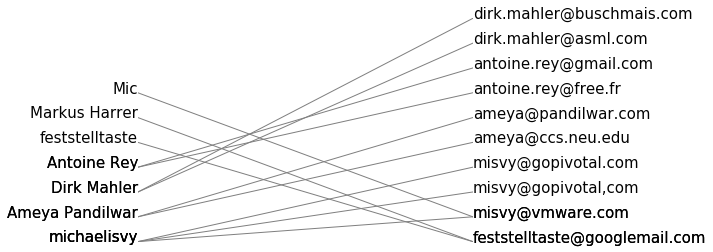

In [11]:
fig1 = plt.figure(facecolor='white')
ax1 = plt.axes(frameon=False)
ax1.set_frame_on(False)
ax1.get_xaxis().tick_bottom()
ax1.axes.get_yaxis().set_visible(False)
ax1.axes.get_xaxis().set_visible(False)

# simply plot all the data (imperfection: duplicated will be displayed in bold font)
for data in plot_data.iterrows():
    row = data[1]
    plt.text(0, row['normalized_index_name'], row['name'], fontsize=15, horizontalalignment="right")
    plt.text(1, row['normalized_index_email'], row['email'], fontsize=15, horizontalalignment="left")
    plt.plot([0,1],[row['normalized_index_name'],row['normalized_index_email']],'grey', linewidth=1.0)

Alright! Here we are! We see that multiple authors use multiple email addresses. And I see a pattern that could be used to get better data. Do you, too? 

## Interlude - end

If you skipped the interlude section: I just visualized / demonstrated that there are different email addresses per author (and vise versa). Some authors choose to use another email address and some choose a different name for committing to the repositories (and a few did both things).

## Data Wrangling

The situation above is a typical case of a little data messiness and &ndash; to demotivate you &ndash; absolutely normal. So we have to do some data correction before we start our analysis. Otherwise, we would ignore reality completely and deliver wrong results. This could damage our reputation as a data analyst and is something we have to avoid at all costs!

We want to fix the problem with the multiple authors having multiple email addresses (but are the same persons). We need a mapping between them. Should we do it manually? That would be kind of crazy. As mentioned above, there is a pattern in the data to fix that. We simply use the name of the email address as an identifier for a person.

Let's give it a try by extracting the name part from the email address with a simple split.

In [12]:
commits['nickname'] = commits['email'].apply(lambda x : x.split("@")[0])
commits.head()

,email,name,nickname
0,feststelltaste@googlemail.com,Markus Harrer,feststelltaste
1,feststelltaste@googlemail.com,feststelltaste,feststelltaste
2,feststelltaste@googlemail.com,feststelltaste,feststelltaste
3,feststelltaste@googlemail.com,feststelltaste,feststelltaste
4,feststelltaste@googlemail.com,feststelltaste,feststelltaste


That looks pretty good. Now we want to get only the person's real name instead of the nickname. We use a little heuristic to determine the "best fitting" real name and replace all the others. For this, we need group by nicknames and determine the real names.

In [13]:
def determine_real_name(names):
    
    real_name = ""
    
    for name in names:
        # assumption: if there is a whitespace in the name, 
        # someone thought about it to be first name and surname
        if " " in name:
            return name
        # else take the longest name
        elif len(name) > len(real_name):
            real_name = name
            
    return real_name
        
commits_grouped = commits[['nickname', 'name']].groupby(['nickname']).agg(determine_real_name)
commits_grouped = commits_grouped.rename(columns={'name' : 'real_name'})
commits_grouped.head()

,real_name
nickname,
Andrej1,AndrejGajdos
ameya,Ameya Pandilwar
angel.aguilera,Angel Aguilera
antoine.rey,Antoine Rey
armagan.ersoz,kadinyazilimci


That looks great! Now we switch back to our previous DataFrame by joining in the new information.

In [14]:
commits = commits.merge(commits_grouped, left_on='nickname', right_index=True)
# drop duplicated for better displaying
commits.drop_duplicates().head()

,email,name,nickname,real_name
0,feststelltaste@googlemail.com,Markus Harrer,feststelltaste,Markus Harrer
1,feststelltaste@googlemail.com,feststelltaste,feststelltaste,Markus Harrer
27,feststelltaste@users.noreply.github.com,Markus,feststelltaste,Markus Harrer
29,dirk.mahler@buschmais.com,Dirk Mahler,dirk.mahler,Dirk Mahler
75,dirk.mahler@globalfoundries.com,dmahler,dirk.mahler,Dirk Mahler


That should be enough data cleansing for today!

# Analysis
Now that we have valid data, we can produce some new insights.

## Top 10 committers
Easy tasks first: We simply produce a table with the Top 10 committers. We group by the real name and count every commit by using a subset (only the <tt>email</tt> column) of the DataFrame to only get on column returned. We rename the returned columns to <tt>commits</tt> for displaying reasons (would otherwise be <tt>email</tt>). Then we just list the top 10 entries after sorting appropriately.

In [15]:
committers = commits.groupby('real_name')[['email']]\
  .count().rename(columns={'email' : 'commits'})\
    .sort_values('commits', ascending=False)
committers.head(10)

,commits
real_name,
michaelisvy,298
Antoine Rey,112
Dirk Mahler,51
Keith Donald,35
Markus Harrer,29
Costin Leau,28
Tomas Repel,5
Thibault Duchateau,5
Cyrille Le Clerc,5


In [16]:
committers.head(10)

,commits
real_name,
michaelisvy,298
Antoine Rey,112
Dirk Mahler,51
Keith Donald,35
Markus Harrer,29
Costin Leau,28
Tomas Repel,5
Thibault Duchateau,5
Cyrille Le Clerc,5


## Committer Distribution
Next, we create a pie chart to get a good impression of the committers.

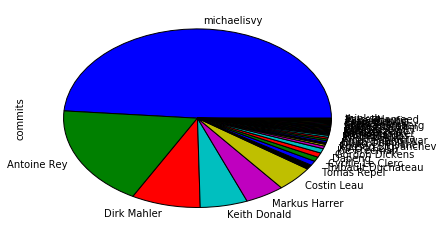

In [17]:
committers['commits'].plot(kind='pie')

Uhh...that looks ugly and kind of weird. Let's first try to fix the mess on the right side that shows all authors with minor changes by summing up their number of commits. We will use a threshold value that makes sense with our data (e. g. the committers that contribute more than 3/4 to the code) to identify them. A nice start is the description of the current data set.

In [18]:
committers_description = committers.describe()
committers_description

,commits
count,37.000000
mean,16.540541
std,51.868742
min,1.000000
25%,1.000000
50%,1.000000
75%,5.000000
max,298.000000


OK, we want the 3/4 main contributors...

In [19]:
threshold = committers_description.loc['75%'].values[0]
threshold

5.0

...that is > 75% of the commits of all contributors.

In [20]:
minor_committers = committers[committers['commits'] <= threshold]
minor_committers.head()

,commits
real_name,
Tomas Repel,5
Thibault Duchateau,5
Cyrille Le Clerc,5
Dapeng,5
Gordon Dickens,5


These are the entries we want to combine to our new "Others" section. But we don't want to loose the number of changes, so we store them for later usage.

In [21]:
others_number_of_changes = minor_committers.sum()
others_number_of_changes

commits    59
dtype: int64

Now we are deleting all authors that are in the <tt>author_minor_changes</tt>'s DataFrame. To not check on the threshold value from above again, we reuse the already calculated DataFrame.

In [22]:
main_committers = committers[~committers.isin(minor_committers)]
main_committers.tail()

,commits
real_name,
Colin But,NaN
Craig Dennis,NaN
Mike Eltsufin,NaN
Faisal Hameed,NaN
thinksh,NaN


This gives us for the contributors with just a few commits missing values for the <tt>changes</tt> column, because these values were in the <tt>author_minor_changes</tt> DataFrame. We drop all Nan values to get only the major contributors.

In [23]:
main_committers = main_committers.dropna()
main_committers

,commits
real_name,
michaelisvy,298.0
Antoine Rey,112.0
Dirk Mahler,51.0
Keith Donald,35.0
Markus Harrer,29.0
Costin Leau,28.0


We add the "Others" row by appending to the DataFrame

In [24]:
main_committers.loc["Others"] = others_number_of_changes
main_committers

,commits
real_name,
michaelisvy,298.0
Antoine Rey,112.0
Dirk Mahler,51.0
Keith Donald,35.0
Markus Harrer,29.0
Costin Leau,28.0
Others,59.0


Almost there, you redraw with some styling and minor adjustments.

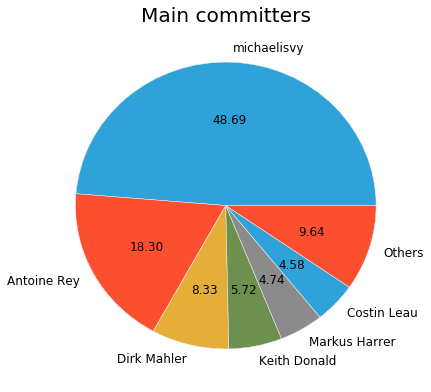

In [25]:
# some configuration for displaying nice diagrams
plt.style.use('fivethirtyeight')
plt.figure(facecolor='white')

ax = main_committers['commits'].plot(
    kind='pie', figsize=(6,6), title="Main committers", 
    autopct='%.2f', fontsize=12)
# get rid of the distracting label for the y-axis
ax.set_ylabel("")

# Summary
I hope you saw that there are some minor difficulties in working with data. We got the big problem with the authors and email addresses that we solved by correcting the names. We also transformed an ugly pie chart into a management-grade one.

This analysis also gives you some handy lines of code for some common data analysis tasks.